In [1]:
import random
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter

import tensorflow as tf

from CNNModels import SoundDenoisingModel
from utils.data_generators import DenoisingDataGenerator
from utils.utils import reconstruct_audio_from_mel, load_mel, show_mel_spectra

In [2]:
assert tf.test.is_built_with_cuda(), "Установлена CPU версия tensorflow"
assert tf.config.list_physical_devices('GPU'), "Не обнаружено GPU на устройстве"

# Описание решения

Изначально, предполагалось решать задачу с помощью автоэнкодеров для изображений https://www.tensorflow.org/tutorials/generative/autoencoder. Несмотря на то, что во время тренировки значения MSE-loss уменьшались, качество данных при инференсе модели было неудовлетворительным.
Затем было выбрано решение описанное в статье https://arxiv.org/abs/1609.07132, которое и реализовано в данном ноутбуке. Архитектура нейросети отличается тем, что изображение mel-спектрограммы рассматривается как временной ряд: зашумленная спектрограмма разбивается на сегменты по 8 соседних Фурье-векторов (k-8, k-7, ..., k), которые подаются на вход нейросети и сопоставляется с вектором k незашумленной спектрограммы при обучении и, тем самым, реализуется авторегрессивный подход many-to-one. При обучении каждая спектрограмма разбивается на окна по 8 векторов без перекрытий для уменьшения нагрузки на вычислительные ресурсы. При инференсе, окно разбивки - скользящее от начального до конечного значения по оси времени с единичным шагом. 

Выбранная нейросеть легковесная и имеет skip-connection-ы, которые делают ее обучение устойчивым даже на малых выборках данных. Для оптимизации обучения, оно производилось лишь на 1-ой части train-данных (train.part1).

При обучении достигалась точность по mse до 0.236 на валидационной выборке, однако при инференсе модели иногда, на реконструированных аудио заметен "свист", хотя исчезла основная часть шумов. Для устранения шума предлагается делать медианную фильтрацию спектрограммы вдоль временной оси с окном (3, 1). Таким образом можно снизить присутствие "свиста", хотя при этом может произойти незначительное зашумление звука. 

Обучение производилось на видеокарте ноутбука nvidia 1650Ti с 4 гб оперативной памяти. Версия Tensorflow - 2.9.1.

# Конфигурирование

рекомендуемая структура тренировочных данных

```new_folder/
├─ train.part1/
│  ├─ clean/
│  │  ├─ 20/
│  │  ├─ 25/
│  ├─ noisy/
│  │  ├─ 20/
│  │  ├─ 25/
├─ val/
│  ├─ clean/
│  ├─ noisy/

In [3]:
trained_model_filepath = "pretrained_models/denoising"

configs = {
    "image_classes" : ("clean", "noisy"), # классы для классификации

    "training_params" : {
        "numSegments" : 8, # количество фурье-веторов для авторегрессии (numSegments в статье)
        "numFeatures" : 80, # ширина sft-окна (она же размерность фурье-веторов)
        "batch_size" : 3,
        "epochs" : 5,
        "learning_rate":{ # параметры экспоненциального динамического уменьшения learning_rate
            "base_learning_rate" : 3e-4,
            "exponential_decay_steps" : 10_000,
            "decay_rate" : 0.9,
        },

        "metrics" : [tf.keras.metrics.RootMeanSquaredError('mse')],
        "shuffle" : True
    },

    "data_folders" : {
        "train" : ["data/train.part1"], # путь до папки с clean/noisy тренировочными данными
        "val" : ["data/val"] # путь до папки с clean/noisy валидационными данными
    }
}

# Загрузка данных

In [4]:
training_params = configs["training_params"]

batch_size = training_params["batch_size"]
numSegments = training_params["numSegments"]
image_classes = configs["image_classes"]
shuffle = training_params["shuffle"]

traingen = DenoisingDataGenerator(data_folders=configs["data_folders"]["train"],
                                  batch_size=batch_size,
                                  numSegments=numSegments,
                                  shuffle=shuffle)
valgen = DenoisingDataGenerator(data_folders=configs["data_folders"]["train"],
                                batch_size=batch_size,
                                numSegments=numSegments,
                                shuffle=shuffle)

# Тренировка

In [5]:
model = SoundDenoisingModel(l2_strength=0,
                            numFeatures=80,
                            numSegments=8)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=training_params["learning_rate"]["base_learning_rate"],
    decay_steps=training_params["learning_rate"]["exponential_decay_steps"],
    decay_rate=training_params["learning_rate"]["decay_rate"])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=training_params['metrics'])

mcp_save = tf.keras.callbacks.ModelCheckpoint(trained_model_filepath,
                                              save_format="h5",
                                              save_best_only=True,
                                              monitor='val_loss',
                                              mode='min')

In [6]:
history = model.fit(traingen,
                    validation_data=valgen,
                    callbacks=[mcp_save],
                    epochs=training_params["epochs"])

Epoch 1/5
4000/4000 [==============================] - ETA: 0s - loss: 0.0994 - mse: 0.3152

INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


4000/4000 [==============================] - 3776s 944ms/step - loss: 0.0994 - mse: 0.3152 - val_loss: 0.0687 - val_mse: 0.2621
Epoch 2/5
4000/4000 [==============================] - ETA: 0s - loss: 0.0726 - mse: 0.2695

INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


4000/4000 [==============================] - 3612s 903ms/step - loss: 0.0726 - mse: 0.2695 - val_loss: 0.0613 - val_mse: 0.2475
Epoch 3/5
4000/4000 [==============================] - ETA: 0s - loss: 0.0684 - mse: 0.2616

INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


4000/4000 [==============================] - 3572s 893ms/step - loss: 0.0684 - mse: 0.2616 - val_loss: 0.0592 - val_mse: 0.2433
Epoch 4/5
4000/4000 [==============================] - ETA: 0s - loss: 0.0660 - mse: 0.2569

INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


INFO:tensorflow:Assets written to: pretrained_models\denoising\assets


4000/4000 [==============================] - 3633s 908ms/step - loss: 0.0660 - mse: 0.2569 - val_loss: 0.0557 - val_mse: 0.2360
Epoch 5/5
4000/4000 [==============================] - 3602s 901ms/step - loss: 0.0644 - mse: 0.2538 - val_loss: 0.0596 - val_mse: 0.2442


# Статистика по тренировке

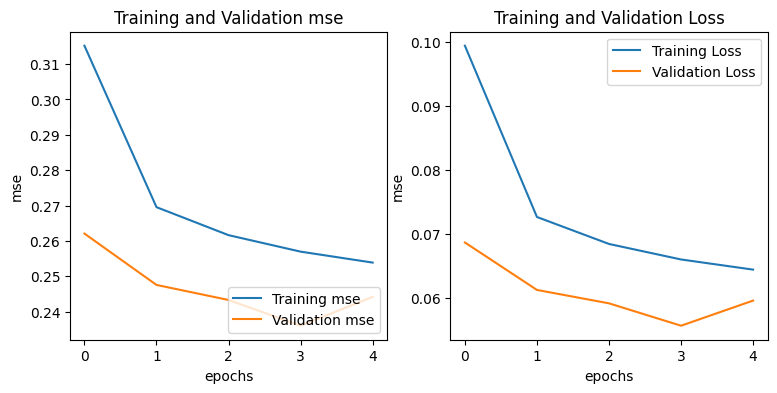

In [7]:
acc = history.history['mse']
val_acc = history.history['val_mse']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(training_params["epochs"])

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training mse')
plt.plot(epochs_range, val_acc, label='Validation mse')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.title('Training and Validation mse')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.title('Training and Validation Loss')
plt.show()

графики свидетельствуют о том, что у нас нет перееобучения.

# Инференс на файле

In [8]:
model.load_weights(trained_model_filepath)

In [9]:
filepath = r"data\train.part1\noisy\20\20_205_20-205-0012.npy"
out_folder_path="out_sounds"

Path(out_folder_path).mkdir(parents=True, exist_ok=True)

noised_mel = load_mel(filepath)
clean_mel = load_mel(filepath.replace("noisy", "clean"))
unnoised_mel = model.predict_unnoised_mel_npy_file(filepath)

26/26 [==============================] - 0s 3ms/step


In [10]:
reconstruct_audio_from_mel(noised_mel, f"{out_folder_path}/noised.flac")
reconstruct_audio_from_mel(clean_mel, f"{out_folder_path}/clean.flac")
reconstruct_audio_from_mel(unnoised_mel, f"{out_folder_path}/unnoised.flac")

footprint=np.ones((3, 1))
reconstruct_audio_from_mel(median_filter(unnoised_mel, footprint=footprint), f"{out_folder_path}/unnoised_median.flac")